In [1]:
import os
os.chdir("../../../../")

import itertools
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy

#!pip install pmdarima
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from pmdarima import model_selection
from pmdarima import auto_arima
from scripts.python.ts_utils import * 
from scripts.python.tsmodel import * 

import warnings
warnings.filterwarnings('ignore')

In [2]:
filedir = os.getcwd() + "/data/tourism/palau/intermediate/"
filepaths = [filedir + file for file in os.listdir(filedir) if ".csv" in file]
filepaths

['/Users/czhang/Desktop/pacific-observatory/data/tourism/palau/intermediate/palau_merged.csv',
 '/Users/czhang/Desktop/pacific-observatory/data/tourism/palau/intermediate/palau_monthly_visitor.csv']

## Preprocessing
### Use `stringency_index` as a proxy

In [3]:
covid_data = pd.read_csv(os.getcwd() + "/data/tourism/owid-covid-data.csv")

# There is no Palau's stringency index, using Oceania's mean as the proxy
oceania_covid = (covid_data[covid_data.continent == "Oceania"]
                 .reset_index()
                 .drop("index", axis=1))
oceania_index = oceania_covid[["date", "location", "stringency_index"]]
oceania_index["date"] = pd.to_datetime(oceania_index["date"])
oceania_index = oceania_index.groupby("date").mean().reset_index()
oceania_index.head(5)

,date,stringency_index
0,2020-01-26,5.560
1,2020-01-27,5.560
2,2020-01-28,5.560
3,2020-01-29,5.560
4,2020-01-30,8.335


In [4]:
oceania_index["year"], oceania_index["month"] = \
    oceania_index["date"].dt.year, oceania_index["date"].dt.month
oceania_index = oceania_index.groupby(["year", "month"]).mean().reset_index()
oceania_index["date"] = [str(year) + "-" + str(month)
                         for year, month in zip(oceania_index.year, oceania_index.month)]
oceania_index["date"] = pd.to_datetime(oceania_index["date"])

In [5]:
oceania_index.head(5)

,year,month,stringency_index,date
0,2020,1,6.485000,2020-01-01
1,2020,2,18.961379,2020-02-01
2,2020,3,41.960753,2020-03-01
3,2020,4,82.458000,2020-04-01
4,2020,5,64.930000,2020-05-01


### Read Palau's intermediate files

In [6]:
palau = pd.read_csv(filepaths[-1]).drop("Unnamed: 0", axis=1)
palau["Date"] = pd.to_datetime(palau["Date"])
palau = (palau.merge(oceania_index, how="left", left_on="Date", right_on="date")
         .drop("date", axis=1)
         .fillna(0)
         .rename({"stringency_index": "covid"}, axis=1))
palau.head(5)

,Date,JAPAN,SOUTH KOREA,TAIWAN,CHINA,USA/CANADA,EUROPE,OTHERS,Total,year,month,covid
0,2007-06-01,856.0,1291.0,3245.0,86.0,669.0,99.0,463.0,6709.0,0.0,0.0,0.0
1,2007-07-01,2119.0,1366.0,3269.0,33.0,653.0,144.0,437.0,8021.0,0.0,0.0,0.0
2,2007-08-01,3476.0,1354.0,3046.0,46.0,580.0,256.0,438.0,9196.0,0.0,0.0,0.0
3,2007-09-01,3022.0,910.0,2497.0,61.0,559.0,145.0,401.0,7595.0,0.0,0.0,0.0
4,2007-10-01,1807.0,1082.0,2298.0,49.0,774.0,390.0,395.0,6795.0,0.0,0.0,0.0


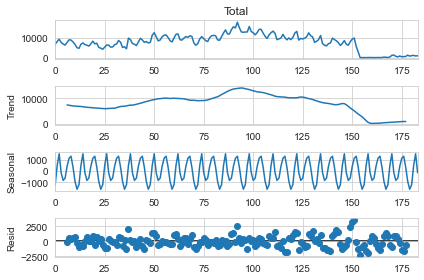

In [7]:
decompose = seasonal_decompose(palau["Total"], period=12, model="additive")
f = decompose.plot()
plt.rcParams.update({'figure.figsize': (10, 9)})

## SARIMAX

### Transformation & Train-Test Split

[Scaled Logit Transformation](https://otexts.com/fpp3/limits.html#forecasts-constrained-to-an-interval):
$$y = \log\left(\frac{x-a}{b-x}\right)$$
and Inverse Transformation is: 
$$ x  = \frac{(b-a)e^y}{1+e^y} + a $$


In [8]:
ps = SARIMAXPipeline(data=palau, y_var="Total", exog_var="covid", transform_method="scaledlogit")
ps.transform()

training size : 165, testing size : 19


<AxesSubplot:>

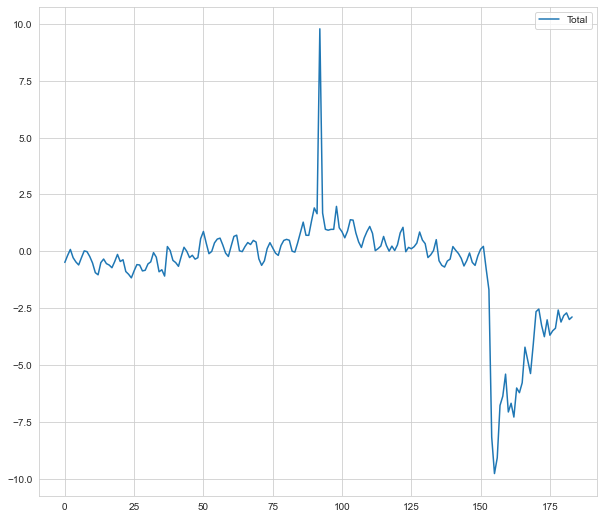

In [9]:
ps.transformed_y.plot()

### Stepwise searching

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=495.583, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=495.423, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=480.621, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=462.052, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=493.439, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=463.889, Time=0.02 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=462.394, Time=0.19 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=461.090, Time=0.06 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=460.952, Time=0.20 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=496.616, Time=0.09 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=453.215, Time=0.36 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=452.321, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AI

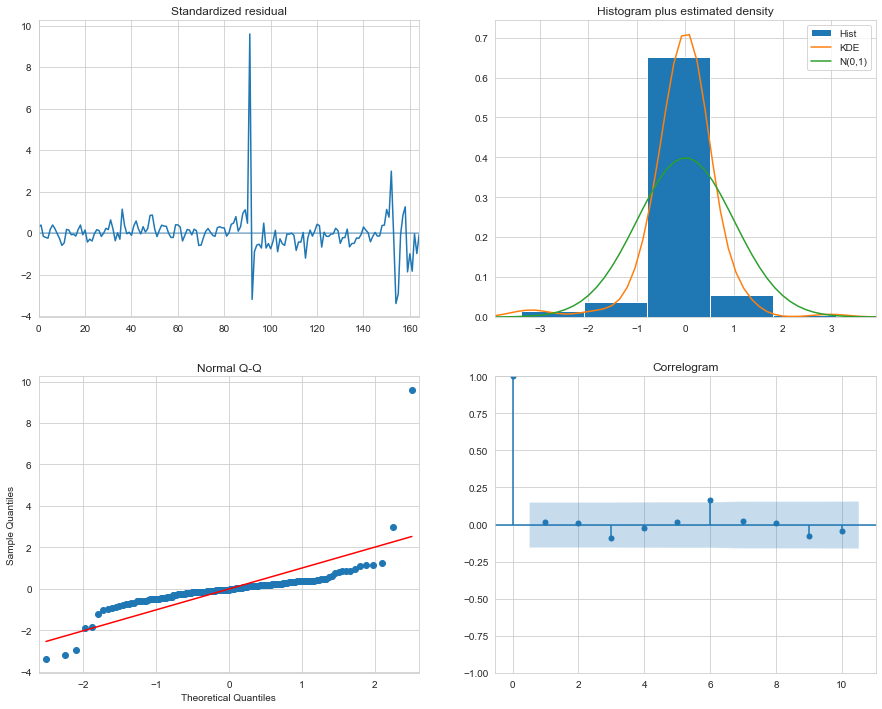

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (1, 1, 1),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (1, 0, 1, 12),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': True}

In [10]:
ps.stepwise_search()

### Manually Searching

In [11]:
# Set parameter range
p, d, q = range(0, 3), range(0, 2), range(0, 3)
P, D, Q, s = range(0, 3), range(0, 2), range(0, 3), [12]

# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
all_param = list(itertools.product(pdq, seasonal_pdq))

# Search the minimim aic
ps_msres = ps.manual_search(params=all_param)

Tried out SARIMAX(0, 0, 0)x(0, 0, 0, 12) - AIC:503.87
Tried out SARIMAX(0, 0, 0)x(0, 0, 1, 12) - AIC:493.07
Tried out SARIMAX(0, 0, 0)x(0, 0, 2, 12) - AIC:492.1
Tried out SARIMAX(0, 0, 0)x(0, 1, 0, 12) - AIC:509.92
Tried out SARIMAX(0, 0, 0)x(0, 1, 1, 12) - AIC:479.11
Tried out SARIMAX(0, 0, 0)x(0, 1, 2, 12) - AIC:479.44
Tried out SARIMAX(0, 0, 0)x(1, 0, 0, 12) - AIC:489.77
Tried out SARIMAX(0, 0, 0)x(1, 0, 1, 12) - AIC:489.93
Tried out SARIMAX(0, 0, 0)x(1, 0, 2, 12) - AIC:491.9
Tried out SARIMAX(0, 0, 0)x(1, 1, 0, 12) - AIC:490.48
Tried out SARIMAX(0, 0, 0)x(1, 1, 1, 12) - AIC:477.73
Tried out SARIMAX(0, 0, 0)x(1, 1, 2, 12) - AIC:478.61
Tried out SARIMAX(0, 0, 0)x(2, 0, 0, 12) - AIC:490.18
Tried out SARIMAX(0, 0, 0)x(2, 0, 1, 12) - AIC:491.91
Tried out SARIMAX(0, 0, 0)x(2, 0, 2, 12) - AIC:491.02
Tried out SARIMAX(0, 0, 0)x(2, 1, 0, 12) - AIC:484.39
Tried out SARIMAX(0, 0, 0)x(2, 1, 1, 12) - AIC:478.36
Tried out SARIMAX(0, 0, 0)x(2, 1, 2, 12) - AIC:479.28
Tried out SARIMAX(0, 0, 1)x(0,

Tried out SARIMAX(1, 0, 2)x(1, 1, 0, 12) - AIC:461.18
Tried out SARIMAX(1, 0, 2)x(1, 1, 1, 12) - AIC:433.57
Tried out SARIMAX(1, 0, 2)x(1, 1, 2, 12) - AIC:434.49
Tried out SARIMAX(1, 0, 2)x(2, 0, 0, 12) - AIC:450.93
Tried out SARIMAX(1, 0, 2)x(2, 0, 1, 12) - AIC:449.5
Tried out SARIMAX(1, 0, 2)x(2, 0, 2, 12) - AIC:450.54
Tried out SARIMAX(1, 0, 2)x(2, 1, 0, 12) - AIC:451.0
Tried out SARIMAX(1, 0, 2)x(2, 1, 1, 12) - AIC:435.54
Tried out SARIMAX(1, 0, 2)x(2, 1, 2, 12) - AIC:436.44
Tried out SARIMAX(1, 1, 0)x(0, 0, 0, 12) - AIC:479.55
Tried out SARIMAX(1, 1, 0)x(0, 0, 1, 12) - AIC:477.76
Tried out SARIMAX(1, 1, 0)x(0, 0, 2, 12) - AIC:478.28
Tried out SARIMAX(1, 1, 0)x(0, 1, 0, 12) - AIC:508.99
Tried out SARIMAX(1, 1, 0)x(0, 1, 1, 12) - AIC:448.92
Tried out SARIMAX(1, 1, 0)x(0, 1, 2, 12) - AIC:450.83
Tried out SARIMAX(1, 1, 0)x(1, 0, 0, 12) - AIC:476.82
Tried out SARIMAX(1, 1, 0)x(1, 0, 1, 12) - AIC:468.85
Tried out SARIMAX(1, 1, 0)x(1, 0, 2, 12) - AIC:470.82
Tried out SARIMAX(1, 1, 0)x(1,

Tried out SARIMAX(2, 1, 2)x(0, 0, 1, 12) - AIC:451.64
Tried out SARIMAX(2, 1, 2)x(0, 0, 2, 12) - AIC:453.76
Tried out SARIMAX(2, 1, 2)x(0, 1, 0, 12) - AIC:491.19
Tried out SARIMAX(2, 1, 2)x(0, 1, 1, 12) - AIC:433.82
Tried out SARIMAX(2, 1, 2)x(0, 1, 2, 12) - AIC:435.8
Tried out SARIMAX(2, 1, 2)x(1, 0, 0, 12) - AIC:452.16
Tried out SARIMAX(2, 1, 2)x(1, 0, 1, 12) - AIC:448.71
Tried out SARIMAX(2, 1, 2)x(1, 0, 2, 12) - AIC:451.18
Tried out SARIMAX(2, 1, 2)x(1, 1, 0, 12) - AIC:464.47
Tried out SARIMAX(2, 1, 2)x(1, 1, 1, 12) - AIC:435.81
Tried out SARIMAX(2, 1, 2)x(1, 1, 2, 12) - AIC:437.02
Tried out SARIMAX(2, 1, 2)x(2, 0, 0, 12) - AIC:453.04
Tried out SARIMAX(2, 1, 2)x(2, 0, 1, 12) - AIC:450.71
Tried out SARIMAX(2, 1, 2)x(2, 0, 2, 12) - AIC:452.24
Tried out SARIMAX(2, 1, 2)x(2, 1, 0, 12) - AIC:454.32
Tried out SARIMAX(2, 1, 2)x(2, 1, 1, 12) - AIC:437.79
Tried out SARIMAX(2, 1, 2)x(2, 1, 2, 12) - AIC:439.69


### Cross-validation

In [12]:
ps_msres.sort(key=lambda x: x[1])
ps_msres[:5]

[(<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x348449fd0>,
  430.80904692961474,
  ((1, 1, 1), (0, 1, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x2b3253f70>,
  431.0547272687773,
  ((0, 1, 2), (0, 1, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x34b4aff70>,
  431.31847569797935,
  ((2, 0, 1), (0, 1, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x2a596b8e0>,
  431.5867267273098,
  ((1, 0, 2), (0, 1, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x2b302de50>,
  431.59000493786436,
  ((0, 1, 1), (0, 1, 1, 12)))]

In [13]:
ps_models = []
ps_sw = ps.stepwise_model
ps_models.append(pm.ARIMA(
    ps_sw["order"], ps_sw["seasonal_order"],  exog=ps.exog[:ps.training_size]))
for res in ps_msres[:5]:
    order, seasonal_order = res[-1]
    model = pm.ARIMA(order, seasonal_order, exog=ps.exog[:ps.training_size])
    ps_models.append(model)

ps.comp = ps.compare_models(
    y=ps.transformed_y[:ps.training_size],
    exog=ps.exog[:ps.training_size],
    models=ps_models)

[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................
[CV] fold=11 .........................................................
[CV] fold=12 .........................................................
[CV] fold=13 .........................................................
[CV] f

[CV] fold=15 .........................................................
[CV] fold=16 .........................................................
[CV] fold=17 .........................................................
[CV] fold=18 .........................................................
[CV] fold=19 .........................................................
[CV] fold=20 .........................................................
[CV] fold=21 .........................................................
[CV] fold=22 .........................................................
[CV] fold=23 .........................................................


In [14]:
ps.comp

{'model': [ARIMA(order=(1, 1, 1), seasonal_order=(1, 0, 1, 12)),
  ARIMA(order=(1, 1, 1), seasonal_order=(0, 1, 1, 12)),
  ARIMA(order=(0, 1, 2), seasonal_order=(0, 1, 1, 12)),
  ARIMA(order=(2, 0, 1), seasonal_order=(0, 1, 1, 12)),
  ARIMA(order=(1, 0, 2), seasonal_order=(0, 1, 1, 12)),
  ARIMA(order=(0, 1, 1), seasonal_order=(0, 1, 1, 12))],
 'cv_scores': [array([108.46388483,  23.09269142,  72.40956639,  94.84836304,
         117.38200508, 136.6520902 , 182.07143645, 166.28117385,
         198.10996926,  95.44185716, 177.67984369, 198.68824177,
         163.79552702,  49.29007982, 124.74438611, 156.64205968,
         118.89465059, 155.99253798, 145.76390872, 135.60491121,
          69.81454978, 122.52744025, 137.12262572, 154.32767631]),
  array([ 59.46083747,  48.5008139 ,  54.62415759, 103.28969877,
         118.10870816, 161.92650478, 126.07084679, 101.90918207,
          88.43730345, 106.07581107, 171.83034237, 191.08560152,
         131.56954299,  51.33194005,  79.52073519,  62

### Best Logit Scaled Model

In [15]:
best_ps = ps_msres[0][0]
best_ps.save(filedir + "best_scaled.pkl")
best_ps_mod = ps.get_prediction_df(
    best_ps, 19, ps.exog[-ps.test_size:])
lower = palau["Total"].min() - 1
upper = palau["Total"].max() + 1

for col_idx, col in enumerate(best_ps_mod.columns):
    for row_idx, _ in enumerate(best_ps_mod[col]):
        best_ps_mod.iloc[row_idx, col_idx] = ps.inverse_scaledlogit(
            best_ps_mod.iloc[row_idx, col_idx], upper, lower)

In [16]:
best_ps_mod = pd.concat([palau[["Date", "Total"]], best_ps_mod], axis=1)
best_ps_mod.head(20)

,Date,Total,train_pred,mean_se,mean_ci_lower,mean_ci_upper,test_pred
0,2007-06-01,6709.0,8856.000000,NaN,0.000000,NaN,NaN
1,2007-07-01,8021.0,6709.000821,NaN,0.000000,NaN,NaN
2,2007-08-01,9196.0,8020.999098,NaN,0.000000,NaN,NaN
3,2007-09-01,7595.0,9195.998889,NaN,0.000000,NaN,NaN
4,2007-10-01,6795.0,7595.001047,NaN,0.000000,NaN,NaN
5,2007-11-01,6252.0,6795.000819,NaN,0.000000,NaN,NaN
6,2007-12-01,7595.0,6252.000576,NaN,0.000000,NaN,NaN
7,2008-01-01,8911.0,7594.999015,NaN,0.000000,NaN,NaN
8,2008-02-01,8766.0,8910.998750,NaN,0.000000,NaN,NaN
9,2008-03-01,7817.0,8765.999864,NaN,0.000000,NaN,NaN


Text(0.5, 1.0, "Palau's Visitor Arrivals")

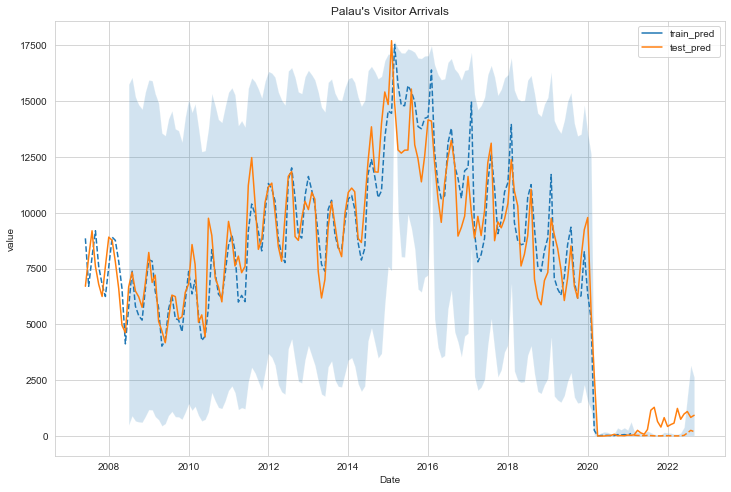

In [17]:
sclaed_viz_df = best_ps_mod[["Date", "train_pred", "test_pred"]].melt(id_vars=["Date"])
sclaed_viz_df["Date"] = pd.to_datetime(sclaed_viz_df["Date"])

fig, ax = plt.subplots(figsize=(12,8))
ax.fill_between(x="Date", y1="mean_ci_lower", y2="mean_ci_upper", data=best_ps_mod, alpha=0.2)
sns.lineplot(data=sclaed_viz_df, x="Date", y="value", hue="variable", linestyle="--")
sns.lineplot(data=best_ps_mod, x="Date", y="Total")
plt.title("Palau's Visitor Arrivals")

In [18]:
# MSE_mod2 = np.square(np.subtract(palau_stats["Total"], palau_stats["mean"])).mean()
# RMSE_mod2 = np.sqrt(MSE_mod2)
# RMSE_mod2

### Best No-Transformation Models (existence of negative values)

training size : 165, testing size : 19
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=2856.017, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2884.661, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2840.759, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2857.665, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2882.701, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2885.557, Time=0.01 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=2829.480, Time=0.38 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=2814.648, Time=0.57 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=2812.832, Time=0.24 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=2857.856, Time=0.13 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=2814.866, Time=0.56 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=2851.614, Time=0.35 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=0.68 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=2814.652,

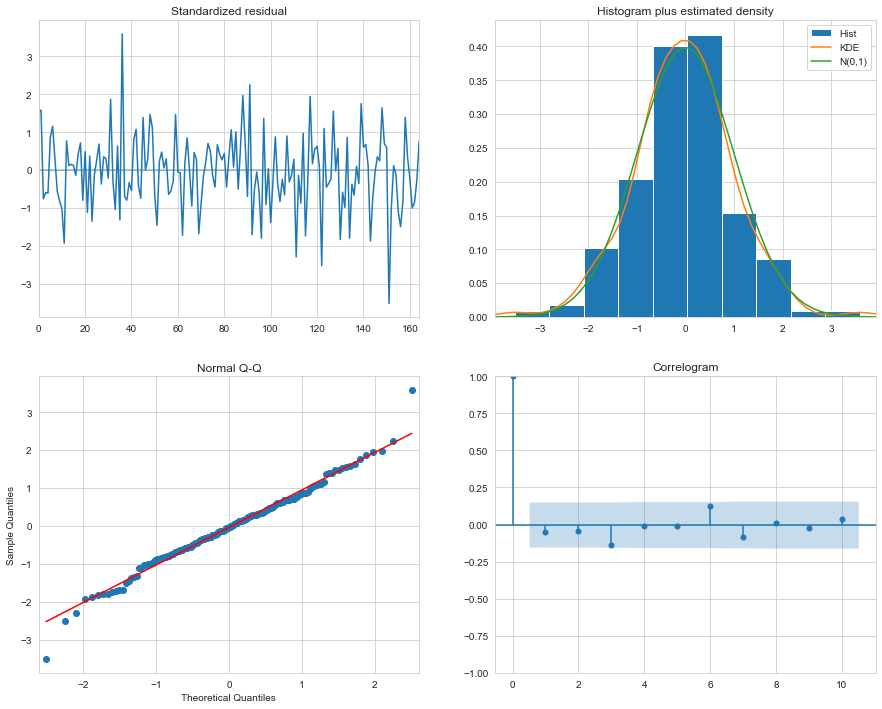

Tried out SARIMAX(0, 0, 0)x(0, 0, 0, 12) - AIC:4163.01
Tried out SARIMAX(0, 0, 0)x(0, 0, 1, 12) - AIC:3311.16
Tried out SARIMAX(0, 0, 0)x(0, 0, 2, 12) - AIC:3242.13
Tried out SARIMAX(0, 0, 0)x(0, 1, 0, 12) - AIC:2793.39
Tried out SARIMAX(0, 0, 0)x(0, 1, 1, 12) - AIC:2788.93
Tried out SARIMAX(0, 0, 0)x(0, 1, 2, 12) - AIC:2790.35
Tried out SARIMAX(0, 0, 0)x(1, 0, 0, 12) - AIC:3042.01
Tried out SARIMAX(0, 0, 0)x(1, 0, 1, 12) - AIC:3041.66
Tried out SARIMAX(0, 0, 0)x(1, 0, 2, 12) - AIC:3048.46
Tried out SARIMAX(0, 0, 0)x(1, 1, 0, 12) - AIC:2790.61
Tried out SARIMAX(0, 0, 0)x(1, 1, 1, 12) - AIC:2790.79
Tried out SARIMAX(0, 0, 0)x(1, 1, 2, 12) - AIC:2785.44
Tried out SARIMAX(0, 0, 0)x(2, 0, 0, 12) - AIC:3042.3
Tried out SARIMAX(0, 0, 0)x(2, 0, 1, 12) - AIC:3046.02
Tried out SARIMAX(0, 0, 0)x(2, 0, 2, 12) - AIC:3099.0
Tried out SARIMAX(0, 0, 0)x(2, 1, 0, 12) - AIC:2788.79
Tried out SARIMAX(0, 0, 0)x(2, 1, 1, 12) - AIC:2783.02
Tried out SARIMAX(0, 0, 0)x(2, 1, 2, 12) - AIC:2789.22
Tried out SA

Tried out SARIMAX(1, 0, 2)x(1, 0, 0, 12) - AIC:2837.23
Tried out SARIMAX(1, 0, 2)x(1, 0, 1, 12) - AIC:2823.57
Tried out SARIMAX(1, 0, 2)x(1, 0, 2, 12) - AIC:2827.76
Tried out SARIMAX(1, 0, 2)x(1, 1, 0, 12) - AIC:2643.45
Tried out SARIMAX(1, 0, 2)x(1, 1, 1, 12) - AIC:2626.96
Tried out SARIMAX(1, 0, 2)x(1, 1, 2, 12) - AIC:2627.0
Tried out SARIMAX(1, 0, 2)x(2, 0, 0, 12) - AIC:2833.86
Tried out SARIMAX(1, 0, 2)x(2, 0, 1, 12) - AIC:2827.76
Tried out SARIMAX(1, 0, 2)x(2, 0, 2, 12) - AIC:2845.25
Tried out SARIMAX(1, 0, 2)x(2, 1, 0, 12) - AIC:2626.24
Tried out SARIMAX(1, 0, 2)x(2, 1, 1, 12) - AIC:2627.16
Tried out SARIMAX(1, 0, 2)x(2, 1, 2, 12) - AIC:2628.18
Tried out SARIMAX(1, 1, 0)x(0, 0, 0, 12) - AIC:2867.15
Tried out SARIMAX(1, 1, 0)x(0, 0, 1, 12) - AIC:2839.62
Tried out SARIMAX(1, 1, 0)x(0, 0, 2, 12) - AIC:2833.46
Tried out SARIMAX(1, 1, 0)x(0, 1, 0, 12) - AIC:2646.8
Tried out SARIMAX(1, 1, 0)x(0, 1, 1, 12) - AIC:2581.59
Tried out SARIMAX(1, 1, 0)x(0, 1, 2, 12) - AIC:2583.03
Tried out SA

Tried out SARIMAX(2, 1, 1)x(2, 0, 0, 12) - AIC:2805.49
Tried out SARIMAX(2, 1, 1)x(2, 0, 1, 12) - AIC:2795.92
Tried out SARIMAX(2, 1, 1)x(2, 0, 2, 12) - AIC:2794.89
Tried out SARIMAX(2, 1, 1)x(2, 1, 0, 12) - AIC:2590.1
Tried out SARIMAX(2, 1, 1)x(2, 1, 1, 12) - AIC:2590.37
Tried out SARIMAX(2, 1, 1)x(2, 1, 2, 12) - AIC:2589.02
Tried out SARIMAX(2, 1, 2)x(0, 0, 0, 12) - AIC:2795.36
Tried out SARIMAX(2, 1, 2)x(0, 0, 1, 12) - AIC:2793.63
Tried out SARIMAX(2, 1, 2)x(0, 0, 2, 12) - AIC:2795.6
Tried out SARIMAX(2, 1, 2)x(0, 1, 0, 12) - AIC:2641.55
Tried out SARIMAX(2, 1, 2)x(0, 1, 1, 12) - AIC:2589.33
Tried out SARIMAX(2, 1, 2)x(0, 1, 2, 12) - AIC:2590.69
Tried out SARIMAX(2, 1, 2)x(1, 0, 0, 12) - AIC:2793.44
Tried out SARIMAX(2, 1, 2)x(1, 0, 1, 12) - AIC:2791.45
Tried out SARIMAX(2, 1, 2)x(1, 0, 2, 12) - AIC:2793.66
Tried out SARIMAX(2, 1, 2)x(1, 1, 0, 12) - AIC:2617.22
Tried out SARIMAX(2, 1, 2)x(1, 1, 1, 12) - AIC:2588.67
Tried out SARIMAX(2, 1, 2)x(1, 1, 2, 12) - AIC:2586.54
Tried out SA

In [19]:
po = SARIMAXPipeline(data=palau, y_var="Total", exog_var="covid", transform_method=None)
po.transform()
po_sw = po.stepwise_search()
po_msres = po.manual_search(params=all_param)
po_msres.sort(key=lambda x: x[1])

po_models = []
po_models.append(pm.ARIMA(
    po_sw["order"], po_sw["seasonal_order"],  exog=po.exog[:po.training_size]))

for res in po_msres[:5]:
    order, seasonal_order = res[-1]
    model = pm.ARIMA(order, seasonal_order, exog=po.exog[:po.training_size])
    po_models.append(model)

In [20]:
ps_comp = po.compare_models(y=po.transformed_y[:po.training_size],
                            exog=po.exog[:po.training_size], models=po_models[1:])

[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................
[CV] fold=11 .........................................................
[CV] fold=12 .........................................................
[CV] fold=13 .........................................................
[CV] f

In [21]:
ps_comp

{'model': [ARIMA(order=(0, 0, 1), seasonal_order=(2, 0, 0, 12)),
  ARIMA(order=(0, 1, 1), seasonal_order=(1, 1, 2, 12)),
  ARIMA(order=(0, 1, 2), seasonal_order=(0, 1, 1, 12)),
  ARIMA(order=(0, 1, 1), seasonal_order=(0, 1, 1, 12)),
  ARIMA(order=(1, 1, 1), seasonal_order=(0, 1, 1, 12))],
 'cv_scores': [array([ 15.762777  ,  25.3984013 ,  13.8500362 ,  17.00489793,
          26.69068766,  25.48874918,  25.52910091,  13.96173781,
          11.7779252 ,  20.61861088,  12.25636612,  25.4464233 ,
          36.28077404,  20.8042802 ,  10.49950246,  22.49515506,
          19.90205421,  20.04576633,  16.6049816 ,  20.13338706,
          26.13557882,  19.75335944,  56.16025881, 147.27393574]),
  array([ 35.49179795,  38.84791079,  37.32626431,  20.95678051,
          23.22776158,  10.55611214,  26.37808059,  32.77661478,
          36.11462914,  47.39987106,  17.59770811,  12.49576708,
          10.75281395,  37.59799777,  50.10112223,  40.26554052,
          39.97080604,  36.93607326,  29.1227

In [22]:
best_original = po_msres[5][0]
best_original.save(filedir+"best_original.pkl")
original_mod = po.get_prediction_df(best_original, steps=po.test_size, exog=po.exog[-po.test_size:])
original_mod.columns.name = None
original_mod = pd.concat([palau[["Date", "Total"]], original_mod], axis=1)
original_mod.head(5)

,Date,Total,train_pred,mean_se,mean_ci_lower,mean_ci_upper,test_pred
0,2007-06-01,6709.0,0.000000,2030.879716,-3980.451100,3980.451100,NaN
1,2007-07-01,8021.0,5852.661101,1748.506879,2425.650592,9279.671610,NaN
2,2007-08-01,9196.0,7288.725678,1736.032474,3886.164554,10691.286803,NaN
3,2007-09-01,7595.0,8690.674154,1733.360781,5293.349451,12087.998856,NaN
4,2007-10-01,6795.0,7668.983489,1733.064368,4272.239746,11065.727232,NaN


Text(0.5, 1.0, "Palau's Visitor Arrivals")

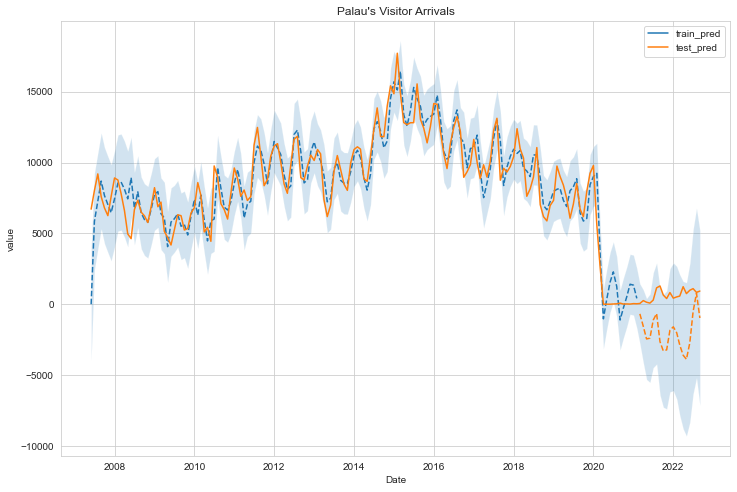

In [23]:
original_viz_df = original_mod[["Date", "train_pred", "test_pred"]].melt(id_vars=["Date"])

fig, ax = plt.subplots(figsize=(12,8))
ax.fill_between(x="Date", y1="mean_ci_lower", y2="mean_ci_upper", data=original_mod, alpha=0.2)
sns.lineplot(data=original_viz_df, x="Date", y="value", hue="variable", linestyle="--")
sns.lineplot(data=original_mod, x="Date", y="Total")
plt.title("Palau's Visitor Arrivals")

## VARMAX

In [24]:
palau_merged = pd.read_csv(filepaths[0]).drop("Unnamed: 0", axis=1)
palau_merged["date"] = [str(year) + '-' + str(month)
                        for year, month in zip(palau_merged.Year, palau_merged.Month)]
palau_merged["date"] = pd.to_datetime(palau_merged["date"])
palau_merged = palau_merged.merge(oceania_index, how="left", on="date").drop([
    "year", "month"], axis=1).fillna(0)
palau_merged.head(5)

,Year,Month,Seats_arrivals_intl,Seats_arrivals_total,Number_of_flights_intl,Number_of_flights_total,Date,JAPAN,SOUTH KOREA,TAIWAN,CHINA,USA/CANADA,EUROPE,OTHERS,Total,date,stringency_index
0,2019,1,13048.0,13048.0,75.0,75.0,2019-01-01,1953.0,1169.0,919.0,2072.0,626.0,310.0,280.0,7329.0,2019-01-01,0.0
1,2019,2,13281.0,13281.0,74.0,74.0,2019-02-01,2055.0,1035.0,1092.0,4059.0,702.0,438.0,371.0,9752.0,2019-02-01,0.0
2,2019,3,12870.0,12870.0,73.0,73.0,2019-03-01,2434.0,1090.0,1190.0,2549.0,826.0,483.0,461.0,9033.0,2019-03-01,0.0
3,2019,4,10806.0,10806.0,64.0,64.0,2019-04-01,1756.0,808.0,1099.0,3182.0,777.0,368.0,415.0,8405.0,2019-04-01,0.0
4,2019,5,11472.0,11472.0,67.0,67.0,2019-05-01,1288.0,1095.0,1393.0,2489.0,607.0,185.0,421.0,7478.0,2019-05-01,0.0


In [70]:
palau_diff = palau_merged[["Total", "Seats_arrivals_intl", "Number_of_flights_intl"]].diff().dropna()
palau_diff["Date"] = palau_merged["Date"][1:]
get_adf_df(palau_diff, ["Total", "Seats_arrivals_intl", "Number_of_flights_intl"])

,Test Statistic,p-value,# Lags Used,Number of Observations Used,Critical Value (1%),Critical Value (5%),Critical Value (10%)
Total,-2.622492,0.088437,5.0,38.0,-3.615509,-2.941262,-2.609200
Seats_arrivals_intl,-5.476862,0.000002,0.0,43.0,-3.592504,-2.931550,-2.604066
Number_of_flights_intl,-5.583135,0.000001,0.0,43.0,-3.592504,-2.931550,-2.604066


In [26]:
from sklearn.model_selection import ParameterGrid
param_grid = {'p': [1, 2, 3], 'q': [1, 2, 3], 'tr': ['n', 'c', 't', 'ct']}
pg = list(ParameterGrid(param_grid))

In [71]:
from statsmodels.tsa.api import VARMAX

for a, b in enumerate(pg):
    print(f' Running for {b}')
    p = b.get('p')
    q = b.get('q')
    tr = b.get('tr')
    model = VARMAX(palau_diff[["Total", "Seats_arrivals_intl", "Number_of_flights_intl"]],
                   exog=palau_merged["stringency_index"][1:],
                   order=(p, q), trend=tr).fit(disp=False)
    print(model.aic)

 Running for {'p': 1, 'q': 1, 'tr': 'n'}
1677.2003003485704
 Running for {'p': 1, 'q': 1, 'tr': 'c'}
1681.71263568462
 Running for {'p': 1, 'q': 1, 'tr': 't'}
1675.2799729430876
 Running for {'p': 1, 'q': 1, 'tr': 'ct'}
1680.5932391658093
 Running for {'p': 1, 'q': 2, 'tr': 'n'}
1672.0785164255872
 Running for {'p': 1, 'q': 2, 'tr': 'c'}
1677.186666924898
 Running for {'p': 1, 'q': 2, 'tr': 't'}
1672.9717791065752
 Running for {'p': 1, 'q': 2, 'tr': 'ct'}
1677.9447546523415
 Running for {'p': 1, 'q': 3, 'tr': 'n'}
1691.3859209212749
 Running for {'p': 1, 'q': 3, 'tr': 'c'}
1699.0453714336568
 Running for {'p': 1, 'q': 3, 'tr': 't'}
1690.5288275999214
 Running for {'p': 1, 'q': 3, 'tr': 'ct'}
1695.5857610300145
 Running for {'p': 2, 'q': 1, 'tr': 'n'}
1672.046547411743
 Running for {'p': 2, 'q': 1, 'tr': 'c'}
1679.4627434036508
 Running for {'p': 2, 'q': 1, 'tr': 't'}
1673.3157733218209
 Running for {'p': 2, 'q': 1, 'tr': 'ct'}
1677.7471036243542
 Running for {'p': 2, 'q': 2, 'tr': 'n'}

In [75]:
varma = VARMAX(endog=palau_diff[["Total", "Seats_arrivals_intl", "Number_of_flights_intl"]],
               exog=palau_merged["stringency_index"][1:], order=(1, 1), tr="ct")
varma_res = varma.fit(disp=False)

In [76]:
total_pred = varma_res.get_prediction().summary_frame()
total_pred.columns.name = None
palau_merged["mean"] = total_pred["mean"].cumsum() + palau_merged['Total'][0]

Text(0.5, 1.0, "Palau's Visitor Arrivals")

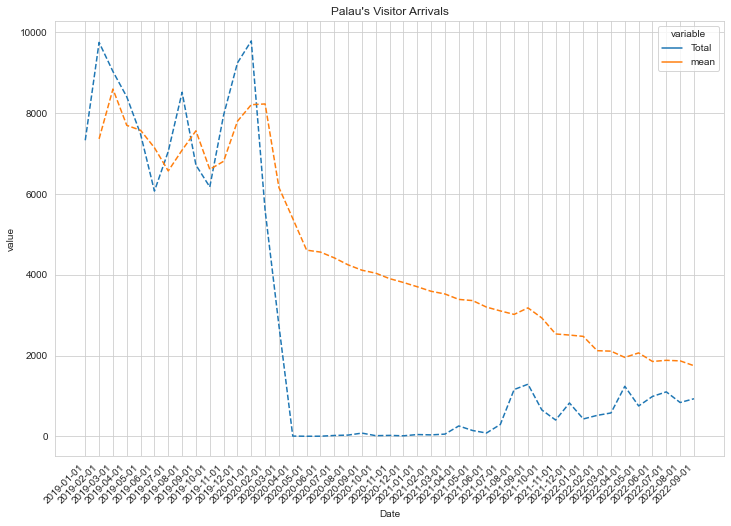

In [77]:
var_viz_df = palau_merged[["Date", "Total", "mean"]].melt(id_vars=["Date"])

fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(data=var_viz_df, x="Date", y="value", hue="variable", linestyle="--")
plt.xticks(rotation=45, ha='right')
plt.title("Palau's Visitor Arrivals")